In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

import urllib
from PIL import Image

In [4]:
PATH = 'data/tawkify/'
image_folder = f'{PATH}train/'
data_csv = PATH+'tw_dem_images.csv'
image_csv = PATH+'image_csv.csv'

model_csv = f'{PATH}current_model_age.csv'

In [5]:
sz=224
# sz=400

### Create Training CSV data from Image CSV

In [ ]:
img_df = pd.read_csv(image_csv)

In [ ]:
plt.imshow(plt.imread(img_df.local_photo.iloc[np.random.randint(10)]))

In [ ]:
size_map = { idx:plt.imread(k.local_photo).shape for idx,k in img_df.iterrows()}

In [ ]:
size_map

In [ ]:
h, w, ch = list(zip(*size_map.values()))

In [ ]:
plt.hist(w)

In [ ]:
w = np.array(w)
plt.hist(w[w<600])

In [ ]:
img_df.head()

In [ ]:
temp_df = img_df.loc[~img_df.User_Age.isna() & (img_df.User_Age < 70) & (img_df.User_Age > 20)]
temp_df = pd.DataFrame(data={'id': temp_df.userID, 'age': temp_df.User_Age}, columns=['id', 'age'])
temp_df.to_csv(model_csv, index=False)

In [ ]:
temp_df.sort_values('age')

### Architecture

In [ ]:
# !rm -rf {PATH}tmp

In [9]:
temp_df = pd.read_csv(model_csv)

In [10]:
temp_df.age.mean()

40.84776243778293

In [11]:
temp_df.shape

(88802, 2)

In [12]:
temp_df.iloc[4204]

id     983011.0
age        49.0
Name: 4204, dtype: float64

In [13]:
arch=resnet50

In [14]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
n = temp_df.shape[0]-1
val_idxs = get_cv_idxs(n)
data = ImageClassifierData.from_csv(path=PATH, folder='train', csv_fname=model_csv, tfms=tfms, suffix='.jpg', val_idxs=val_idxs, continuous=True, bs=32)

In [ ]:
new_data = data.resize(sz, PATH+'tmp')

In [ ]:
# fnames,y,classes = csv_source('train', model_csv, True, '.jpg', continuous=False)

In [15]:
def show_image(idx):
    x,y = data.trn_ds[idx]
    show_img = data.trn_ds.denorm(x)
    print(show_img.shape)
    print('Y value:', y)
    plt.imshow(show_img[0])

(1, 224, 224, 3)
Y value: [36.]


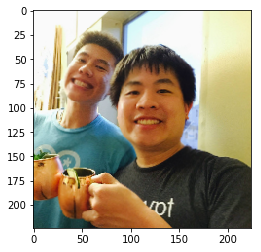

In [18]:
show_image(1)

In [8]:
# learn = ConvLearner.pretrained(arch, data=data, precompute=True)
learn = ConvLearner.pretrained(arch, data=data)

NameError: name 'arch' is not defined

In [ ]:
learn.lr_find()

In [ ]:
learn.sched.plot()

In [ ]:
data.trn_ds

In [ ]:
data.trn_dl

In [ ]:
learn.fit(lrs=1e-2, n_cycle=2,)

In [ ]:
learn.save('tw_age_firstrun1e-2')

In [ ]:
learn.load('tw_age_firstrun1e-2')

In [ ]:
learn.precompute=False

In [ ]:
learn.fit(lrs=1e-2, n_cycle=3)

In [ ]:
learn.save('tw_age_run2')

In [18]:
learn.unfreeze()

In [ ]:
learn.lr_find()

In [ ]:
learn.sched.plot()

In [ ]:
learn.fit(lrs=[1e-4,1e-3,1e-2], n_cycle=3, cycle_len=1)

In [ ]:
learn.save('tw_age_unfreeze1')

In [ ]:
learn.load('tw_age_unfreeze1')

In [ ]:
learn.fit(lrs=[1e-4,1e-3,1e-2], n_cycle=3, cycle_mult=2)

In [ ]:
learn.save('tw_age_unfreeze2_nc3cm2')

In [19]:
learn.load('tw_age_unfreeze2_nc3cm2')

In [ ]:
log_preds, y = learn.TTA()
probs = np.exp(log_preds)
accuracy(log_preds,y), metrics.log_loss(y, probs)

In [ ]:
preds = np.argmax(log_preds, axis=1)
# np.array(preds==y).mean()
preds
# accuracy(log_preds,y)

### Test image

In [20]:
test_image_url = 'https://images-na.ssl-images-amazon.com/images/M/MV5BMTk4MDM0MDUzM15BMl5BanBnXkFtZTcwOTI4MzU1Mw@@._V1_UY317_CR7,0,214,317_AL_.jpg'

In [111]:
test_image_file = f'{PATH}test_images/test1.jpg'
test_image_file = f'{PATH}test_images/kenneth_s.jpg'
# test_image_file = f'{PATH}test_images/age_img/IMG_2776.jpg'
# test_image_file = f'{PATH}test_images/age_img/IMG_8274.jpg'
# test_image_file = f'{PATH}test_images/age_img/IMG_3135.jpg'
# test_image_file = f'{PATH}test_images/age_img/IMG_8819.jpg'
# test_image_file = f'{PATH}test_images/age_img/IMG_9370.jpg'
# test_image_file = f'{PATH}test_images/age_img/IMG_2793.jpg'
# test_image_file = f'{PATH}test_images/grandma_test1.jpg'
# test_image_file = f'{PATH}test_images/lzl_test1.jpg'
# test_image_file = f'{PATH}test_images/age_img/IMG_9625.jpg'

# test_image_file = f'{PATH}test_images/jackie_test1.jpg'

In [112]:
# urllib.request.urlretrieve(test_image_url, test_image_file)

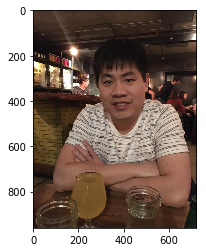

In [113]:
plt.imshow(plt.imread(test_image_file))

In [114]:
val_tfms = tfms[1]

In [115]:
# test_image = val_tfms(plt.imread(test_image_file))
test_image = val_tfms(open_image(test_image_file))


In [116]:
test_image.shape

(3, 220, 220)

In [117]:
eval_mode = learn.model.eval()
# needed so that we know we are in evaluation mode. Otherwise will throw an exception
# equivalent to learn.model.train(False)

In [118]:
age = learn.predict_array([test_image])[0]

In [119]:
print(f'Age:', age[0])

Age: 39.0155


In [83]:
data.classes

['21.0',
 '22.0',
 '23.0',
 '24.0',
 '25.0',
 '26.0',
 '27.0',
 '28.0',
 '29.0',
 '30.0',
 '31.0',
 '32.0',
 '33.0',
 '34.0',
 '35.0',
 '36.0',
 '37.0',
 '38.0',
 '39.0',
 '40.0',
 '41.0',
 '42.0',
 '43.0',
 '44.0',
 '45.0',
 '46.0',
 '47.0',
 '48.0',
 '49.0',
 '50.0',
 '51.0',
 '52.0',
 '53.0',
 '54.0',
 '55.0',
 '56.0',
 '57.0',
 '58.0',
 '59.0',
 '60.0',
 '61.0',
 '62.0',
 '63.0',
 '64.0',
 '65.0',
 '66.0',
 '67.0',
 '68.0',
 '69.0']

## FIgure out this thing

In [ ]:
trn_tfms = tfms[0]
dl = data.trn_dl

In [ ]:
t = tqdm(iter(data.trn_dl), leave=False, total=len(data.trn_ds)/64)
try:
#     trn_tfms(open_image(test_image_file))
    for a in t:
        pass
except Exception as e:
    print(e)
    print(user_id)
    print(test_image_file)

In [ ]:
first_batch = next(iter(dl))

In [ ]:
first_batch[0][0].shape

In [ ]:
temp_df.head()

In [ ]:
for idx, row in tqdm(temp_df.iterrows(), total=temp_df.shape[0]):
    user_id = int(row.id)
    test_image_file = f'{PATH}train/{user_id}.jpg'
    try:
        trn_tfms(open_image(test_image_file))
    except Exception as e:
        print(e)
        print(user_id)
        print(test_image_file)

In [ ]:
from concurrent.futures import ThreadPoolExecutor, wait, as_completed
def transform_img(user_id):
    test_image_file = f'{PATH}train/{user_id}.jpg'
    try:
        img = open_image(test_image_file)
        trn_tfms(img)
    except Exception as e:
        print(e)
        print(user_id)
        print(test_image_file)

subset_df = temp_df
futures = []
with ProcessPoolExecutor(8) as executor:
    for idx, row in subset_df.iterrows():
        futures.append(executor.submit(transform_img, int(row.id)))

    kwargs = {
        'total': len(futures),
        'unit': 'nap',
        'unit_scale': True,
        'leave': True,
        'disable': False
    }
    for x in tqdm(as_completed(futures), **kwargs):
        pass

In [ ]:
trn_tfms(first_batch[0][0])